In [4]:
import matplotlib.pyplot as plt
from matplotlib import transforms

def rainbow_text(x, y, strings, colors, orientation='horizontal',
                 ax=None, **kwargs):
    """
    Take a list of *strings* and *colors* and place them next to each
    other, with text strings[i] being shown in colors[i].

    Parameters
    ----------
    x, y : float
        Text position in data coordinates.
    strings : list of str
        The strings to draw.
    colors : list of color
        The colors to use.
    orientation : {'horizontal', 'vertical'}
    ax : Axes, optional
        The Axes to draw into. If None, the current axes will be used.
    **kwargs
        All other keyword arguments are passed to plt.text(), so you can
        set the font size, family, etc.
    """
    if ax is None:
        ax = plt.gca()
    t = ax.transData
    canvas = ax.figure.canvas

    assert orientation in ['horizontal', 'vertical']
    if orientation == 'vertical':
        kwargs.update(rotation=90, verticalalignment='bottom')

    for s, c in zip(strings, colors):
        text = ax.text(x, y, s, color=c, transform=t, **kwargs)
        
        # Need to draw to update the text position.
        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        if orientation == 'horizontal':
            t = transforms.offset_copy(
                text.get_transform(), x=ex.width, units='dots')
        else:
            t = transforms.offset_copy(
                text.get_transform(), y=ex.height, units='dots')

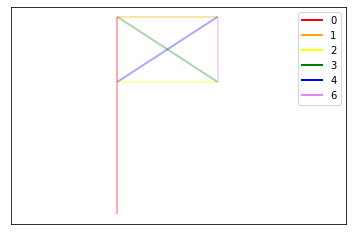

In [208]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import collections as mc
from matplotlib import rc
from matplotlib.lines import Line2D

import colorsys

# Use this function to color however - default is to color by index in the number
DIGIT_COLORING_FUNCTION = lambda origin, scale, rotation, reflection, index, length: tuple(list(colorsys.hsv_to_rgb(index/length/2, 1.0, 0.5)) + [0.5])

LARGE_SEGMENT_SCALAR = 0.5 # How big are the longer line segments?
SMALL_SEGMENT_SCALAR = 0.33 # How big are the smaller line segments?
SCALE_FACTOR = 0.33 # How much does each layer shrink?

# The digit ordering, rotation and reflection wise
ROTATION_ORDER = (0, 0, 180, 180)
REFLECTION_ORDER = (0, 1, 1, 0)

# The fundamental line segments that are composed to make the full digits
FUNDAMENTAL_LINE_SETS = {
    'vline': [(0, -LARGE_SEGMENT_SCALAR), (0, LARGE_SEGMENT_SCALAR)],
    '1line': [(0, LARGE_SEGMENT_SCALAR), (SMALL_SEGMENT_SCALAR, LARGE_SEGMENT_SCALAR)],
    '2line': [(0, LARGE_SEGMENT_SCALAR-SMALL_SEGMENT_SCALAR), (SMALL_SEGMENT_SCALAR, LARGE_SEGMENT_SCALAR-SMALL_SEGMENT_SCALAR)],
    '3line': [(0, LARGE_SEGMENT_SCALAR), (SMALL_SEGMENT_SCALAR, LARGE_SEGMENT_SCALAR-SMALL_SEGMENT_SCALAR)],
    '4line': [(0, LARGE_SEGMENT_SCALAR-SMALL_SEGMENT_SCALAR), (SMALL_SEGMENT_SCALAR, LARGE_SEGMENT_SCALAR)],
    '6line': [(SMALL_SEGMENT_SCALAR, LARGE_SEGMENT_SCALAR-SMALL_SEGMENT_SCALAR), (SMALL_SEGMENT_SCALAR, LARGE_SEGMENT_SCALAR)]
}

# The full digit compositions
DIGIT_POINT_SETS = {
    '0': ['vline'],
    '1': ['vline', '1line'],
    '2': ['vline', '2line'],
    '3': ['vline', '3line'],
    '4': ['vline', '4line'],
    '5': ['vline', '1line', '4line'],
    '6': ['vline', '6line'],
    '7': ['vline', '1line', '6line'],
    '8': ['vline', '2line', '6line'],
    '9': ['vline', '1line', '2line', '6line']
}

def rotate(origin, point, angle):
    # Simple rotation of a point, clockwise
    angle = -np.radians(angle)
    ox, oy = origin
    px, py = point

    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return qx, qy

# Plot a single digit on an axis given an origin, rotation, reflection, and scale
def plot_digit_branch(digit, ax, origin, rotation, reflection, scale, length):
    global DIGIT_POINT_SETS, FUNDAMENTAL_LINE_SETS
    # Assemble the canonical lines
    lines = [FUNDAMENTAL_LINE_SETS[line_primitive] for line_primitive in DIGIT_POINT_SETS[str(digit[0])]]
    if reflection:
        # Reflect if present
        x, y = np.transpose(lines)
        lines = np.transpose([-1*np.array(x), np.array(y)])
    if rotation != 0:
        # Rotate if present
        lines = [[rotate(origin, p, rotation) for p in points] for points in lines]
    if scale != 1:
        # Scale of present
        lines = [[np.array(p) * scale for p in points] for points in lines]
    # Construct a color s.t. scale determines hue and rotation determines saturation
    #c = colorsys.hsv_to_rgb(*(float(scale/SCALE_FACTOR*0.9), 0.5+0.5*((float(rotation)+360)%360)/360.0, 0.5))
    c = DIGIT_COLORING_FUNCTION(origin, scale, rotation, reflection, int(digit[1]), length)
    # Plot the lines
    lc = mc.LineCollection(lines, colors=c, linewidths=2, alpha=SCALE_FACTOR)
    ax.add_collection(lc)
    # Return the digit, its index in the number, and the color, for later plotting
    return ((str(digit[0]), int(digit[1])), c)

# Note that this function isn't perfect - it does some approximations that for larger numbers result in a depth-first instead of breadth-first drawing
# Should be reimplemented with a queue
def _plot_number(number, ax, origin=(0, 0), rotation=0, reflection=0, scale=1, is_digits=False, length=None):
    global ROTATION_ORDER, REFLECTION_ORDER
    # The top level may be a number, or an already processed list of digits
    if not is_digits:
        # We want to plot the most significant digits as the largest digits, so the number grows inward, we also track the index for debugging and easy title coloring
        digits = list(reversed(list(zip(str(number), list(range(len(str(number))))))))
    else:
        digits = number
    if length == None:
        length = len(digits)
    # Extract the primary chunks for visualization (vertical is traditional, horizontal is added)
    chunks = [digits[-4:], digits[-8:-4]] # Most Significant, Lease Significant
    # Get the remaining least significant digits for recursive step
    remainder = digits[:-8]
    # Color the digits
    colors = []
    for idx, digit in enumerate(chunks[0]):
        colors.append(plot_digit_branch(digit, ax, origin, rotation+ROTATION_ORDER[idx], reflection ^ REFLECTION_ORDER[idx], scale=scale, length=length))
    for idx, digit in enumerate(chunks[1]):
        colors.append(plot_digit_branch(digit, ax, origin, rotation+ROTATION_ORDER[idx]+90, reflection ^ REFLECTION_ORDER[idx], scale=scale, length=length))
    # Chunk the remainder, perform the transformations, and recur
    remainder_chunks = [remainder[-4:], remainder[-8:-4], remainder[-12:-8], remainder[-16:-12]]
    remainder_rotations = [90, 180, 270, 0]
    remainder_origin_offsets = [(0, SCALE_FACTOR), 
                                (SCALE_FACTOR, 0),
                                (0, -SCALE_FACTOR),
                                (-SCALE_FACTOR, 0)]
    remainder_remainders = np.array_split(remainder[:-16], 4)
    for remainder_chunk, remainder_rotation, remainder_origin_offset, remainder_remainder in zip(remainder_chunks, remainder_rotations, remainder_origin_offsets, remainder_remainders):
        if len(remainder_chunk) > 0:
            new_number = list(remainder_chunk)+list(remainder_remainder)
            new_origin = np.array(origin) + remainder_origin_offset
            new_rotation = rotation+remainder_rotation
            new_scale = scale * SCALE_FACTOR
            colors.extend(_plot_number(new_number, ax, new_origin, new_rotation, reflection, new_scale, is_digits=True, length=length))
    return colors

def _color_title(ax, number, unsorted_colors):
    # color the title text digits the same as their associated components
    colors = list(sorted(unsorted_colors, key=lambda x: x[0][1]))
    a = list(str(number))
    c = [x[1] for x in colors]
    rainbow_text(-0.55, 0.55, a, c, ax=ax, ha="center", va="bottom", size="medium")

def plot_number(number, figsize=(10, 10), show_title=True):
    # Plot one number
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize)
    colors = _plot_number(number, ax)
    if show_title:
        _color_title(ax, number, colors)
    ax.set_xlim(-.55, .55)
    ax.set_ylim(-.55, .55)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()
    
def plot_number_grid(numbers, grid_width=10, figsize=(16, 16), show_title=True):
    # Plot a grid of numbers
    grid_height = int(np.ceil(len(numbers)/grid_width))
    fig, axes = plt.subplots(grid_height, grid_width)
    fig.set_size_inches(figsize)
    idx = 0
    for x in range(grid_height):
        for y in range(grid_width):
            axis = axes[x][y]
            colors = _plot_number(numbers[idx], axis)
            if show_title:
                _color_title(axis, numbers[idx], colors)
            axis.set_xlim(-0.55, 0.55)
            axis.set_ylim(-0.55, 0.55)
            axis.axes.xaxis.set_visible(False)
            axis.axes.yaxis.set_visible(False)
            idx += 1
    plt.show()
    
plt.figure()
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']
lc = mc.LineCollection(FUNDAMENTAL_LINE_SETS.values(), colors=colors, linewidths=2, alpha=SCALE_FACTOR)
ax = plt.gca()
ax.add_collection(lc)
ax.set_xlim(-.35, .75)
ax.set_ylim(-.55, .55)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-') for c in colors]
labels = ['0', '1', '2', '3', '4', '6']
plt.legend(lines, labels)

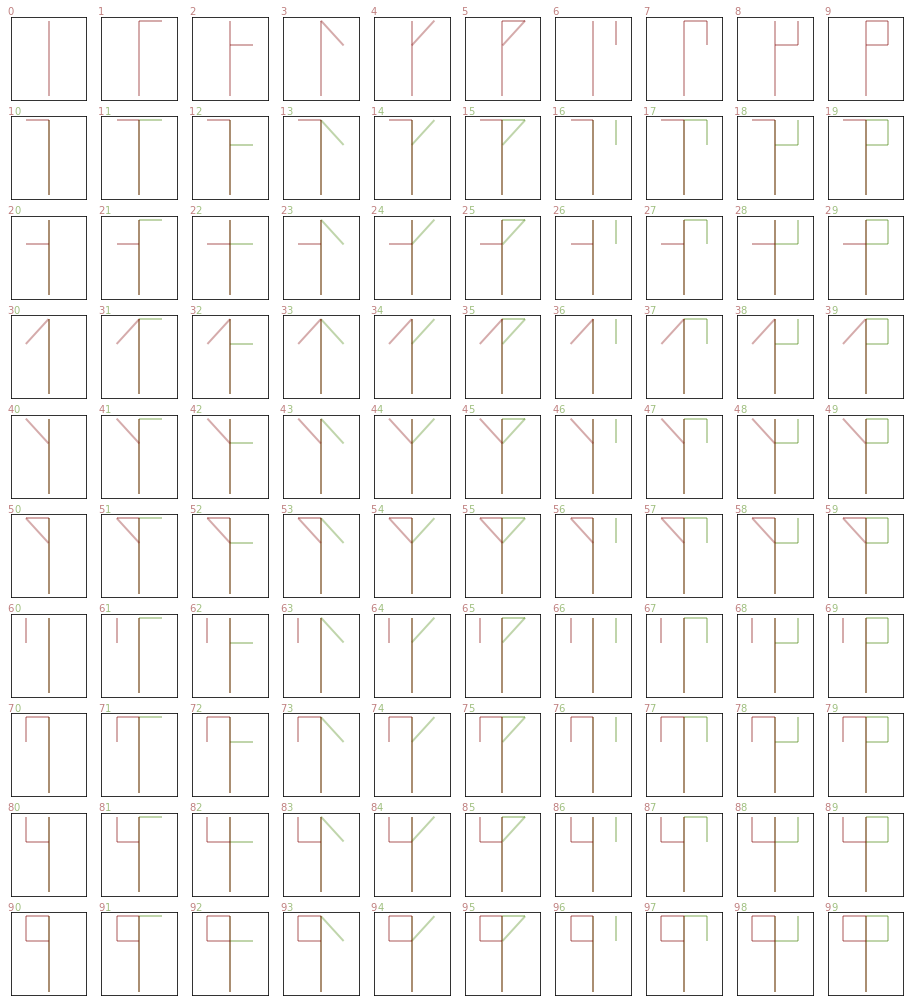

In [147]:
plot_number_grid(list(range(100)), figsize=(16, 18))

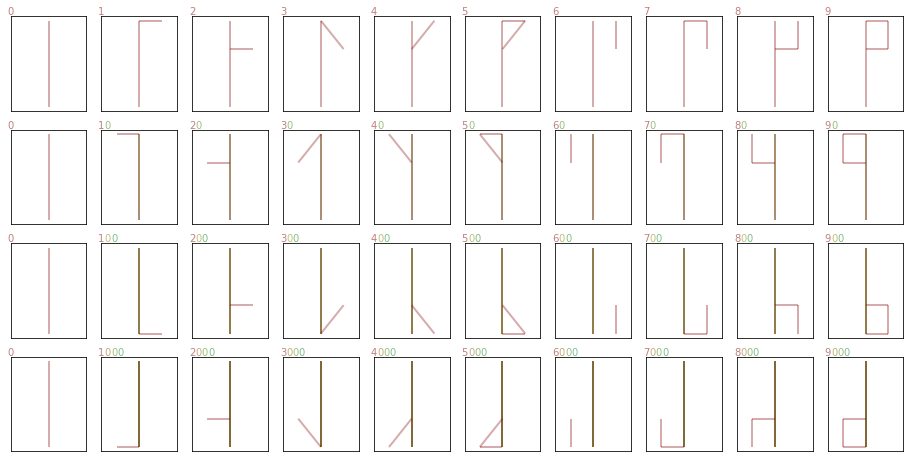

In [148]:
numbers = np.array([np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) * (10**magnitude) for magnitude in range(0, 4)]).flatten()
plot_number_grid(numbers, figsize=(16, 8))

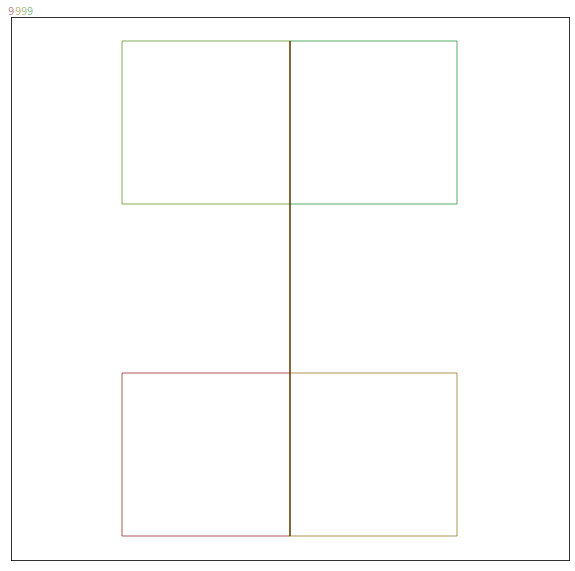

In [149]:
plot_number(9999)

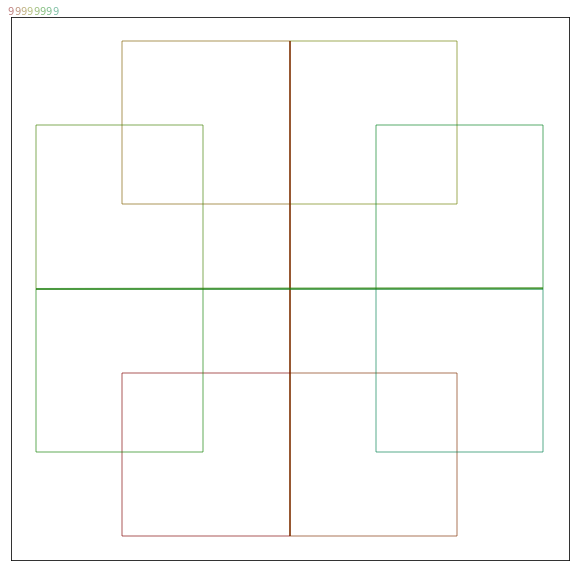

In [150]:
plot_number(99999999)

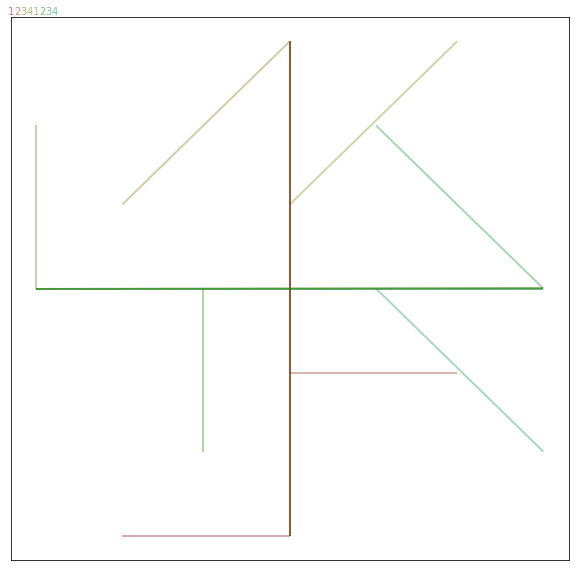

In [151]:
plot_number(12341234)

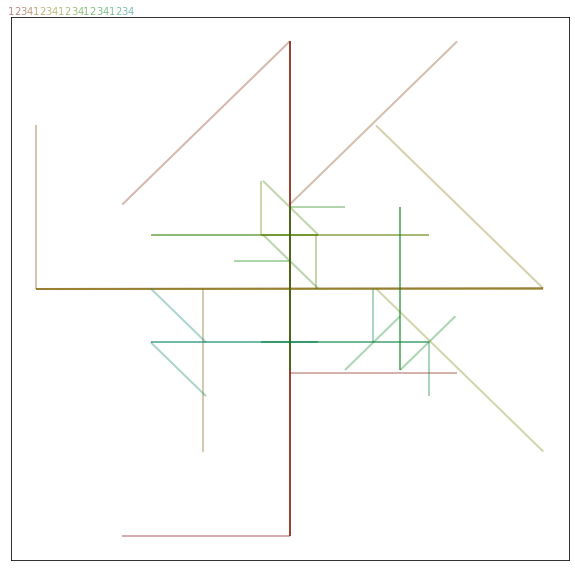

In [152]:
plot_number(12341234123412341234)

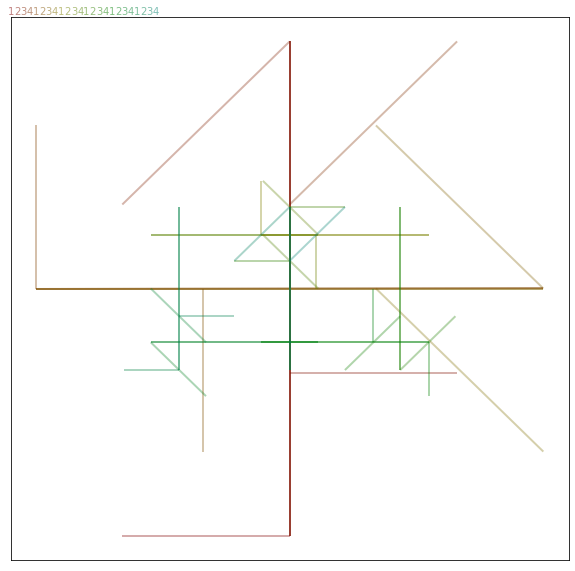

In [153]:
plot_number(123412341234123412341234)

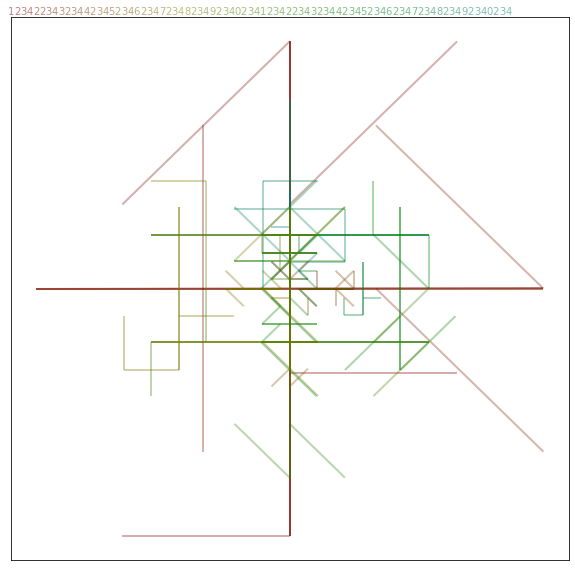

In [154]:
plot_number(12342234323442345234623472348234923402341234223432344234523462347234823492340234)

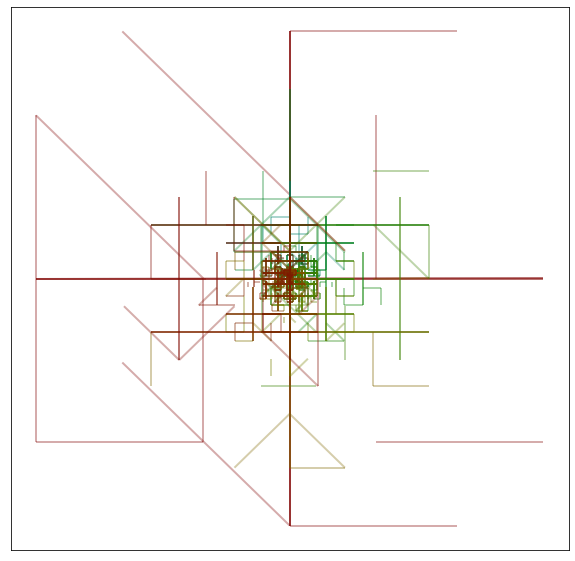

In [157]:
plot_number(314159265358979323846264338327950288419716939937510582097494459230781640628620899862803482534211706798214808651328230664709384460955058223172535940812848111745028410270193852110555964462294895493038196442881097566593344612847564823378678316527120190914564856692346034861045432664821339360726024914127372458700660631558817488152092096282925409171536436789259036001133053054882046652138414695194151160943305727036575959195309218611738193261179310511854807446237996274956735188575272489122793818301194912983367336244065664308602139494639522473719070217986094370277053921717629317675238467481846766940513200056812714526356082778577134275778960917363717872146844090122495343014654958537105079227968925892354201995611212902196086403441815981362977477130996051870721134999999837297804995105973173281609631859502445945534690830264252230825334468503526193118817101000313783875288658753320838142061717766914730359825349042875546873115956286388235378759375195778185778053217122680661300192787661119590921642019, show_title=False)